## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_P")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,65.149895,0,30.0,0.460200,83.371297,0.508610,89.066304,10.318461,272.893918,...,245.139997,0.385395,209.332939,41.129640,592.191757,3.234648,18110.527190,6.948,2826,6861.9
1,1,67.206024,0,30.0,0.329647,149.712265,0.328176,109.824210,13.761403,289.584573,...,221.932844,0.406722,197.689209,42.149774,568.823992,3.240436,23801.869010,7.090,3792,7378.1
2,0,58.773440,0,30.0,0.385797,104.769354,0.545986,125.678783,15.521177,397.945779,...,283.711655,0.336695,217.002950,41.289080,584.300146,3.069283,17579.374770,6.832,2964,7983.5
3,0,55.096508,0,30.0,0.229011,166.953431,0.275601,112.186834,18.126786,281.793906,...,231.188679,0.498026,232.827358,33.062621,700.120751,3.093719,4888.606116,6.523,3184,8525.1
4,0,48.030117,0,29.0,0.242913,86.816221,0.377439,73.484651,13.463920,207.122381,...,245.120671,0.458936,233.016858,44.574015,686.946759,3.149858,22134.931110,8.253,3419,9320.5


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((522, 22), (224, 22))

In [4]:
imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

In [5]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((522, 22), (224, 22))

In [8]:
sel = ['Age', 'MMSE', 'Hip Entropy', 'ERC ENTROPY', 'ERCs_thicknessbaseline',
       'ERCsVolumebaseline', 'TOTAL_HIPPOCAMPUS_VOLUME']

In [9]:
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Age',
 'MMSE',
 'Hip Entropy',
 'ERC ENTROPY',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'TOTAL_HIPPOCAMPUS_VOLUME']

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((522, 7), (224, 7))

## TPE

In [11]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=5,
                             shuffle=True,
                             random_state=42,
        )
    
    ngb_n_estimators = trial.suggest_int("ngb_n_estimators", 200, 500)
    ngb_learning_rate = trial.suggest_float("ngb_learning_rate", 0.01, 0.1, log=True)    
    model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                              n_estimators=ngb_n_estimators,
                              learning_rate=ngb_learning_rate,
                              verbose=False) 

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [12]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-05-21 12:28:12,809] A new study created in memory with name: no-name-fcb25861-1798-4840-a1f5-73e751fc340f


[I 2025-05-21 12:28:52,410] Trial 0 finished with value: 0.3968515130888567 and parameters: {'ngb_n_estimators': 259, 'ngb_learning_rate': 0.02757866988306885}. Best is trial 0 with value: 0.3968515130888567.
[I 2025-05-21 12:29:38,160] Trial 1 finished with value: 0.4019843633304026 and parameters: {'ngb_n_estimators': 256, 'ngb_learning_rate': 0.06372729377274462}. Best is trial 1 with value: 0.4019843633304026.
[I 2025-05-21 12:30:50,169] Trial 2 finished with value: 0.39615706864441225 and parameters: {'ngb_n_estimators': 436, 'ngb_learning_rate': 0.02387245046217145}. Best is trial 1 with value: 0.4019843633304026.
[I 2025-05-21 12:31:33,932] Trial 3 finished with value: 0.39615706864441225 and parameters: {'ngb_n_estimators': 441, 'ngb_learning_rate': 0.010021152986892636}. Best is trial 1 with value: 0.4019843633304026.
[I 2025-05-21 12:31:48,053] Trial 4 finished with value: 0.4032904128496743 and parameters: {'ngb_n_estimators': 278, 'ngb_learning_rate': 0.011416305892569558}.

In [13]:
study.best_params

{'ngb_n_estimators': 426, 'ngb_learning_rate': 0.07071261865374165}

In [14]:
study.best_value

0.4139865589873035

In [15]:
r = study.trials_dataframe()

r.head()

,number,value,datetime_start,datetime_complete,duration,params_ngb_learning_rate,params_ngb_n_estimators,state
0,0,0.396852,2025-05-21 12:28:12.812471,2025-05-21 12:28:52.410716,0 days 00:00:39.598245,0.027579,259,COMPLETE
1,1,0.401984,2025-05-21 12:28:52.410716,2025-05-21 12:29:38.159735,0 days 00:00:45.749019,0.063727,256,COMPLETE
2,2,0.396157,2025-05-21 12:29:38.162542,2025-05-21 12:30:50.168341,0 days 00:01:12.005799,0.023872,436,COMPLETE
3,3,0.396157,2025-05-21 12:30:50.171611,2025-05-21 12:31:33.932137,0 days 00:00:43.760526,0.010021,441,COMPLETE
4,4,0.403290,2025-05-21 12:31:33.933132,2025-05-21 12:31:48.053456,0 days 00:00:14.120324,0.011416,278,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_16764\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


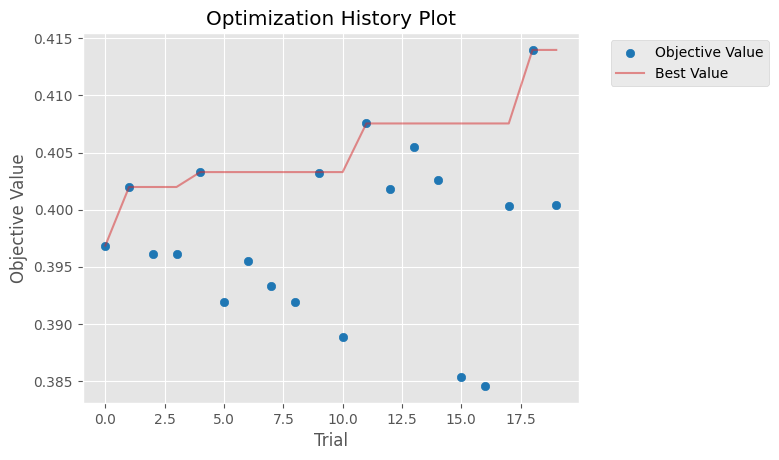

In [16]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_16764\3449611284.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='ngb_learning_rate', ylabel='Objective Value'>,
       <Axes: xlabel='ngb_n_estimators'>], dtype=object)

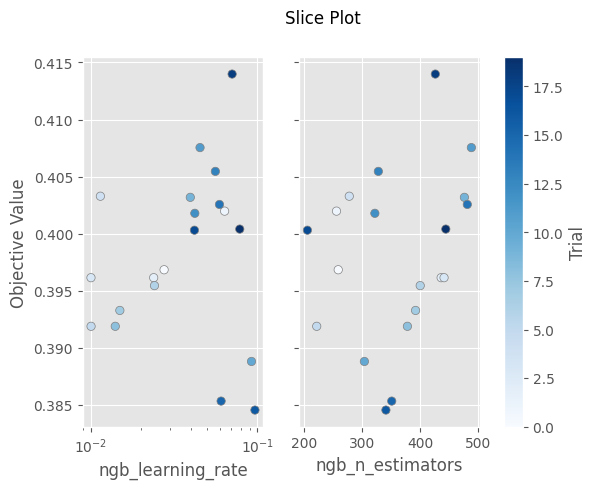

In [17]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["ngb_n_estimators", "ngb_learning_rate"],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_16764\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

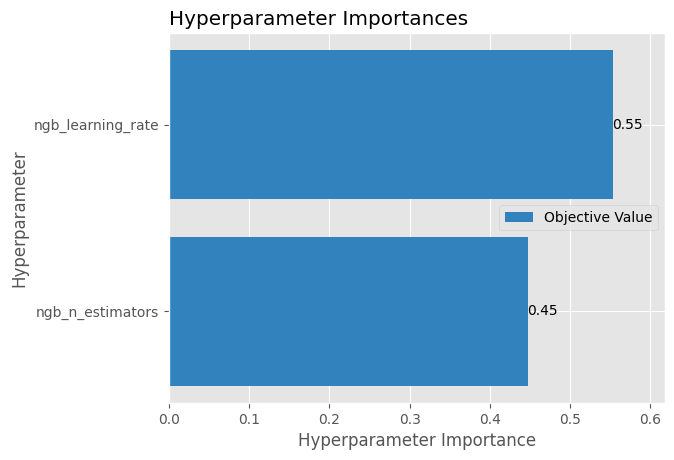

In [18]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_16764\1937692550.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

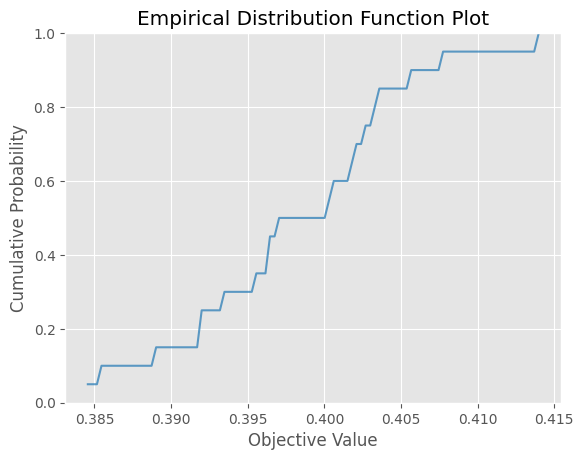

In [19]:
optuna.visualization.matplotlib.plot_edf([study])


### Classification

In [20]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                        n_estimators=study.best_params['ngb_n_estimators'],
                        learning_rate=study.best_params['ngb_learning_rate'], 
                        random_state=42
        )

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=5,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [21]:
trained_ngb_n, metrics_ngb_n = run_model("NGBoost", "Complete", X_train_knn_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", "Boruta", X_train_t, y_train)

[iter 0] loss=0.8352 val_loss=0.0000 scale=2.0000 norm=9.4641
[iter 100] loss=0.1930 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.1930 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 300] loss=0.1930 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 400] loss=0.1930 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.8352 val_loss=0.0000 scale=2.0000 norm=9.4641
[iter 100] loss=0.2047 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.2047 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 300] loss=0.2047 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 400] loss=0.2047 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.8300 val_loss=0.0000 scale=2.0000 norm=9.4641
[iter 100] loss=0.1898 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 200] loss=0.1898 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 300] loss=0.1898 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 400] loss=0.1898 val_loss=0.0000 scale=0.0001 norm=0.0001
[iter 0] loss=0.8300 val_loss=0.0000 scale=1.0

In [22]:
validation_df = pd.concat([metrics_ngb_n, metrics_ngb_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier Metric            Feature Selection Fit Time Total Features               
NGBoost    balanced_accuracy Complete          8.935    22                   0.796   
                             Boruta            5.454    7                    0.732   

                                                                        Std Train  \
Classifier Metric            Feature Selection Fit Time Total Features              
NGBoost    balanced_accuracy Complete          8.935    22                  0.028   
                             Boruta            5.454    7                   0.047   

                                                                        Mean Test  \
Classifier Metric            Feature Selection Fit Time Total Features              
NGBoost    balanced_accuracy Complete          8.935    22                  0.409   
                             Boruta            5.454    7                   0.406   

                                                                        Std Test  
Classifier Metric            Feature Selection Fit Time Total Features            
NGBoost    balanced_accuracy Complete          8.935    22                 0.058  
                             Boruta            5.454    7                  0.018

In [23]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": len(X_train.columns),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [24]:
results = "all"
prediction_df_report = None

if results == "all":

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_knn_t, X_test_knn_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier Classification Time Total Features Metric                             
Boruta            NGBoost    1.782               22             accuracy                   0.891   
                                                                balanced_accuracy          0.783   
                                                                precision                  0.895   
                                                                recall                     0.891   
                                                                f1_weighted                0.881   
                                                                roc_auc_ovr_weighted       0.985   
                             1.431               7              accuracy                   0.875   
                                                                balanced_accuracy          0.744   
                                                                precision                  0.879   
                                                                recall                     0.875   
                                                                f1_weighted                0.867   
                                                                roc_auc_ovr_weighted       0.976   

                                                                                      Test data  
Feature Selection Classifier Classification Time Total Features Metric                           
Boruta            NGBoost    1.782               22             accuracy                  0.848  
                                                                balanced_accuracy         0.566  
                                                                precision                 0.816  
                                                                recall                    0.848  
                                                                f1_weighted               0.824  
                                                                roc_auc_ovr_weighted      0.844  
                             1.431               7              accuracy                  0.826  
                                                                balanced_accuracy         0.554  
                                                                precision                 0.795  
                                                                recall                    0.826  
                                                                f1_weighted               0.809  
                                                                roc_auc_ovr_weighted      0.838

### Export model

In [25]:
trained_ngb_t

NGBClassifier(learning_rate=0.07071261865374165, n_estimators=426,
              random_state=RandomState(MT19937) at 0x21AB6693040)

In [26]:
import pickle

# Save the trained model using pickle
with open("ngboost_model.pkl", "wb") as file:
    pickle.dump(trained_ngb_t, file)

print("NGBoost model saved successfully!")

NGBoost model saved successfully!


In [27]:
# Load the saved model using pickle
with open("ngboost_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)